In [70]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [112]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

class RAE:
    """Recirculated autoencoder.
    
    Parameters
    ----------
    n_neurons : array-like, shape (n_layers)
        Number of neurons per layer.
        It is assumed that the output and input layers are the same size, so no need to specify the final layer.
        Bias nodes should not be included in this count.
        
    act_funcs : function or list of functions, optional.
        Activation function for each layer.
        If a single function, this activation function is used for every layer.
        If two functions and symmetric=True, the first is applied to every layer on the forward pass and the second
        is applied to every layer on the backward pass.
        If len=n_layers, the input to layer n comes from act_funcs[n-1].
        Defaults to hard ReLU.
        
    lr : array-like, optional
        Learning rate.
        If a single number, every layer uses the same learning rate.
        Otherwise, the incoming weights to layer n are updated with lr[n].
        Defaults to 1 for every layer.
        
    reg : array-like, optional
        Regression coefficient, in range [0, 1].
        This corresponds to the "memory" of each layer - what fraction of the activation on the second pass should
        come from the activation on the first pass.
        If a single number, every layer uses the same regression coefficient.
        Otherwise, on the second pass layer n uses reg[n].
        Defaults to 0.75 for every layer.
        
    symmetric : boolean, optional
        Whether to mirror the architecture, such that the encoder and decoder have the same structure in reverse.
        For networks with a single hidden layer this does nothing.
        Defaults to False.
    
    Attributes
    ----------
    n_neurons_ : array, shape (n_layers)
        As above, although it will be modified according to the value of symmetric.
        
    n_layers_ : int
        
    act_funcs_ : list of functions
    
    lr_ : array, shape (n_layers)
    
    reg_ : array, shape (n_layers)
    
    weights_ : list of arrays, length n_layers
        Shapes are given by n_neurons_, taking into account bias nodes.
    
    """
    
    def __init__(self, n_neurons, act_funcs=relu, lr=1, reg=0.75, symmetric=False):
        if symmetric:
            n_neurons = n_neurons + n_neurons[-2:0:-1]

        self.n_neurons_ = np.array(n_neurons)
        self.n_layers_ = len(self.n_neurons_)
        
        if type(act_funcs) is not list:
            self.act_funcs_ = [act_funcs] * (self.n_layers_)
        elif len(act_funcs) == 2 and symmetric:
            self.act_funcs_ = [act_funcs[0]] * (self.n_layers_ // 2) + [act_funcs[1]] * (self.n_layers_ // 2)
        else:
            self.act_funcs_ = act_funcs
            
        if len(self.act_funcs_) != self.n_layers_:
            raise ValueError('An activation function must be defined for every layer.')
               
        if lr * 0 == 0:
            self.lr_ = np.array([lr] * len(n_neurons))
        else:
            self.lr_ = np.array(lr)

        if reg * 0 == 0:
            self.reg_ = np.array([reg] * len(n_neurons))
        else:
            self.reg_ = np.array(reg)
        
        # Initialize weight matrices to random weights in the interval [-0.5, 0.5]
        self.weights_ = []
        
        for i in range(self.n_layers_ - 1):
            self.weights_.append(np.random.random((self.n_neurons_[i] + 1, self.n_neurons_[i+1])) - 0.5)
        
        self.weights_.append(np.random.random((self.n_neurons_[-1] + 1, self.n_neurons_[0])) - 0.5)
        
    def recirculate(self, inputs, update=True):
        a = []
        for n in self.n_neurons_:
            a.append(np.ones((inputs.shape[0], 2, n + 1)))
        
        # First propagation
        a[0][:, 0, :-1] = inputs
        for i in range(self.n_layers_ - 1):
            # "Python code should be self-documenting," they said
            a[i+1][:, 0, :-1] = self.act_funcs_[i](a[i][:, 0, :] @ self.weights_[i])
            
        # Second propagation
        a[0][:, 1, :-1] = self.reg_[0] * a[0][:, 0, :-1] + \
                          (1 - self.reg_[0]) * self.act_funcs_[-1](a[-1][:, 0, :] @ self.weights_[-1])
        for i in range(1, self.n_layers_):
            a[i][:, 1, :-1] = self.reg_[i] * a[i][:, 0, :-1] + \
                              (1 - self.reg_[i]) * self.act_funcs_[i-1](a[i-1][:, 1, :] @ self.weights_[i-1])
            
        # Perform weight updates
        for i in range(len(self.weights_) - 1):
            self.weights_[i] += self.lr_[i] * a[i][:, 1, :].T @ (a[i+1][:, 0, :-1] - a[i+1][:, 1, :-1])
        self.weights_[-1] += self.lr_[-1] * a[-1][:, 0, :].T @ (a[0][:, 0, :-1] - a[0][:, 1, :-1])
        
        return 0.5 * ((inputs - a[0][:, 1, :-1]) ** 2).sum()
    
    def encode(self, inputs, layer):
        a = []
        for n in self.n_neurons_:
            a.append(np.ones((inputs.shape[0], n + 1)))
        
        # First propagation
        a[0][:, :-1] = inputs
        for i in range(self.n_layers_ - 1):
            # "Python code should be self-documenting," they said
            a[i+1][:, :-1] = self.act_funcs_[i](a[i][:, :] @ self.weights_[i])
            
        # Return the desired layer and the reconstructed output
        return a[layer][:, :-1], self.act_funcs_[-1](a[-1][:, :] @ self.weights_[-1])

<IPython.core.display.Javascript object>


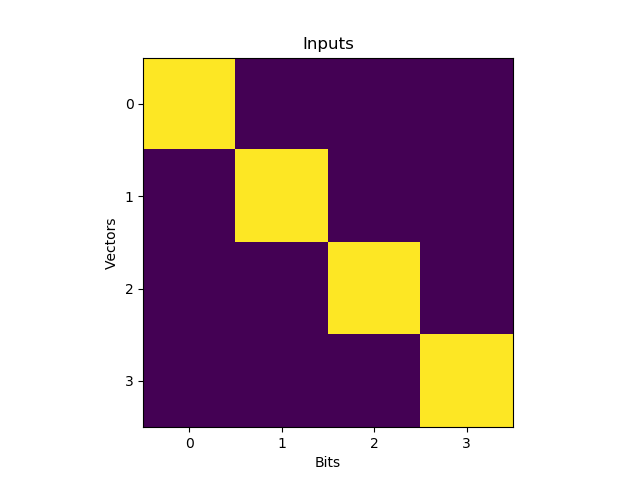

In [106]:
autoencoder = RAE(n_neurons=[4, 2], act_funcs=[tanh, relu], lr=1, reg=[0.75, 0])

inputs = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

fig = plt.figure()
ax = fig.subplots(1, 1)
ax.imshow(recon)
ax.set_title('Inputs')
ax.set_ylabel('Vectors')
ax.set_xlabel('Bits')
ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 1, 2, 3])

error = np.empty(100)
for i in range(100):
    error[i] = autoencoder.recirculate(inputs)

<IPython.core.display.Javascript object>


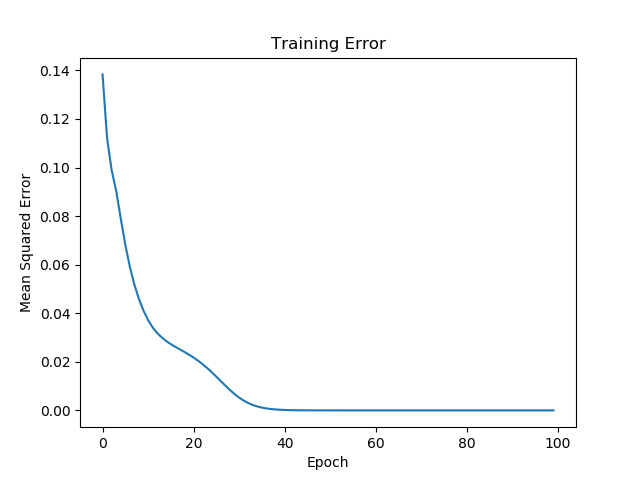

In [108]:
fig = plt.figure()
ax = fig.subplots(1,1)
ax.plot(error)
ax.set_title('Training Error')
ax.set_ylabel('Mean Squared Error')
ax.set_xlabel('Epoch')
plt.show()

<IPython.core.display.Javascript object>


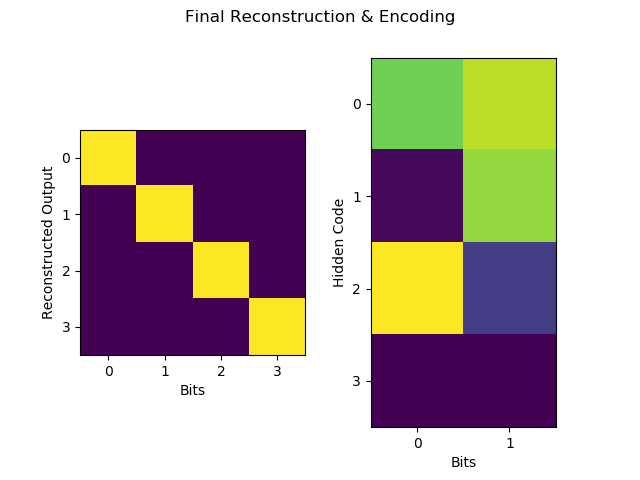

In [109]:
coded, recon = autoencoder.encode(inputs, layer=1)
fig = plt.figure()
fig.suptitle('Final Reconstruction & Encoding')
axes = fig.subplots(1, 2)
axes[0].imshow(recon)
axes[0].set_ylabel('Reconstructed Output')
axes[0].set_xlabel('Bits')
axes[0].set_xticks([0, 1, 2, 3])
axes[0].set_yticks([0, 1, 2, 3])
axes[1].imshow(coded)
axes[1].set_ylabel('Hidden Code')
axes[1].set_xlabel('Bits')
axes[1].set_yticks([0, 1, 2, 3])
axes[1].set_xticks([0, 1])
plt.show()